# Purpose: To perform the actual image registration of the moving image to the fixed image

*Step 1: Import necessary packages*

In [4]:
import os

from glob import glob

import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from numpy.linalg import inv
import ifmodels

%matplotlib inline

SyntaxError: invalid syntax (ifmodels.py, line 17)

*Step 2: Reading in the image*

In [2]:
im3 = io.imread('/Volumes/imagereg/6-26-19-tiffexport/test3.tif')

*Step 3: Seperating the color stack of the image*

In [3]:
red3 = im3[:, :, :, 0]
green3 = im3[:, :, :, 1]
blue3 = im3[:, :, :, 2]

*Step 4: Taking the max intensity projection of the stacks*

In [4]:
im_max_3= np.max(blue3, axis=0)

*Step 5: Visualizng the slice as a checkpoint*

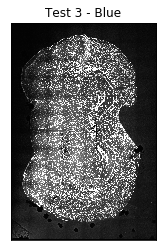

In [5]:
plt.imshow(im_max_3, cmap = 'gray')
plt.title('Test 3 - Blue')
plt.xticks([])
plt.yticks([])

plt.show()

#Problem apparent even in this image which is that the top left corner is
#is less illuminated due to imaging problems (that would be canceled out 
#most likely with averaging though)

*Step 6: Creating a dataframe of the image registration coordinates for moxing (M) and Fixed (F) images*

In [6]:
dfM = pd.read_csv('/Volumes/imagereg/6-26-19-tiffexport/M_regPoints_csv')
dfF = pd.read_csv('/Volumes/imagereg/6-26-19-tiffexport/F_regPoints_csv')

In [7]:
df = pd.concat([dfM, dfF], axis = 1)

In [8]:
df

,M_x,M_y,F_x,F_y
0,287,1822,283,1609
1,1695,3141,1689,2896
2,3383,3225,2389,2914
3,4968,1756,3833,1569
4,3985,264,3029,502
5,1464,239,1089,502


*Step 7: Performing the Linear Algebra for Affine Transformation Coefficients*

In [9]:
row1 = 0

In [10]:
X = np.array([[df.iloc[row1][0], df.iloc[row1][1], 1], [df.iloc[3][0], df.iloc[3][1], 1], [df.iloc[4][0], df.iloc[4][1], 1]])

In [11]:
X_prime = np.array([df.iloc[0][2], df.iloc[3][2], df.iloc[4][2]])

In [12]:
Y_prime =  np.array([df.iloc[0][3], df.iloc[3][3], df.iloc[4][3]])

In [13]:
a,b,c = np.linalg.solve(X, X_prime)
d,e,f = np.linalg.solve(X,Y_prime)

*Step 8: Inverting Affine Transform matrix*

In [14]:
#The transform command below requires the inverse of the affine transformation matrix to work

In [15]:
#Creating a numpy matrix of the values calculated above

In [16]:
ax = np.array([[a, b, c], [d, e, f], [0, 0, 1]])

In [17]:
ax

array([[ 7.58932774e-01,  3.88532728e-02, -5.60436917e+00],
       [ 1.52391923e-03,  7.14143423e-01,  3.07393318e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [18]:
#Getting the inverse

In [19]:
ainv = inv(ax)

In [20]:
#Saving the coefficients as individual variabels to be fed into the transformation function

In [21]:
inva = ainv[0][0]
invb = ainv[0][1]
invc = ainv[0][2]
invd = ainv[1][0]
inve = ainv[1][1]
invf = ainv[1][2]

*Step 9: Peforming the actual Transform*

In [22]:
#Creating an Image object so that the transform function can be used

In [23]:
im = Image.fromarray(im_max_3)

In [24]:
atlas_size = (3200, 4280)

In [25]:
im12 = im.transform(atlas_size, Image.AFFINE, (inva, invb, invc, invd, inve, invf), resample=Image.NEAREST)

In [26]:
#Changing the image back into a numpy array

In [27]:
np_im12 = np.array(im12)

In [28]:
#Showing the registered image

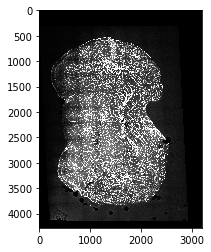

In [29]:
plt.imshow(np_im12, cmap = 'gray')


*Next Steps*
1. Make all the images the same size (insuring that the bran is in the center ofall of them)
2. Putting all the images into a .nii file
3. Creating an efficient process for registerinag multiple slices at once
4. Preprocessing clean up o fthe image so that bubbles and other noise are gone

In [30]:
#Checking homology of the transformations and registration error 

In [31]:
from skimage.measure import compare_ssim

In [32]:
im12 = im.transform(im.size, Image.AFFINE, (inva, invb, invc, invd, inve, invf), resample=Image.NEAREST)

In [33]:
hom_im12 = np.array(im12)

In [34]:
#Closer to 1 is better - but I don't know if this is affected by the fact that the image has been resized 
s = compare_ssim(im_max_3, hom_im12)
s

0.617902392166092

In [35]:
hom_X = np.array([[df.iloc[0][2], df.iloc[0][3], 1], [df.iloc[3][2], df.iloc[3][3], 1], [df.iloc[4][2], df.iloc[4][3], 1]])

In [36]:
hom_X_prime = np.array([df.iloc[0][0], df.iloc[3][0], df.iloc[4][0]])

In [37]:
hom_Y_prime =  np.array([df.iloc[1][1], df.iloc[3][1], df.iloc[4][1]])

In [38]:
homa,homb,homc = np.linalg.solve(hom_X, hom_X_prime)
homd,home,homf = np.linalg.solve(hom_X,hom_Y_prime)

In [39]:
hom_ax = np.array([[homa, homb, homc], [homd, home, homf], [0, 0, 1]])

In [40]:
hom_ax

array([[ 1.31778372e+00, -7.16945767e-02,  2.94237803e+01],
       [-3.71233321e-01,  1.67804273e+00,  5.46088281e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [41]:
ainv

array([[ 1.31778372e+00, -7.16945767e-02,  2.94237803e+01],
       [-2.81203452e-03,  1.40043194e+00, -4.30499179e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])